<a href="https://colab.research.google.com/github/MalenaGlez/TFG-CNN-Resonancias/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación de datos para la clasificación de imágenes cerebrales

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importaciones
import os         # para manejar carpetas y rutas
import cv2        # para leeir imgégenes en OpenCV
import numpy as np
import shutil     # para copiar archivos de un lugar a otro
import random
import matplotlib.pyplot as plt

In [ ]:
class DataPreparation:
    def __init__(self, base_dir: str, processed_dir: str):
        self.base_dir = base_dir
        self.processed_dir = processed_dir
        self.normal_dir = os.path.join(self.base_dir, 'normal')
        self.alzheimers_dir = os.path.join(self.base_dir, 'alzheimers_dataset')
        self.parkinsons_dir = os.path.join(self.base_dir, 'parkinsons_dataset')

        # Rutas de datos ya procesados
        self.train_dir = os.path.join(self.processed_dir, 'train')
        self.test_dir = os.path.join(self.processed_dir, 'test')
        self.val_dir = os.path.join(self.processed_dir, 'val')

        # Ratios para la división en subconjuntos
        self.train_ratio = 0.7
        self.test_ratio = 0.15

        # Tamaño imágenes
        self.target_size = (224, 224)

        # Clases
        self.classes = [d for d in os.listdir(self.base_dir)
            if os.path.isdir(os.path.join(self.base_dir, d))
        ]

    def split_data(self):
        """
        Divide el conjunto de datos en 3 subconjuntos: entrenamiento, prueba y validación.
        train->70%
        test->15%
        validation->15%
        """
        # Comprobación de que las subcarpetas existen en train, test y val
        for category in self.classes:
            os.makedirs(os.path.join(self.train_dir, category), exist_ok=True)
            os.makedirs(os.path.join(self.test_dir, category), exist_ok=True)
            os.makedirs(os.path.join(self.val_dir, category), exist_ok=True)

        # Recorremos las clases
        for category in self.classes:
            # Ruta de la clase
            class_dir = os.path.join(self.base_dir, category)

            # Imágenes dentro de la clase
            files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            random.shuffle(files)

            # Dividir las imágenes en los tres subconjuntos
            n_total = len(files)
            n_train = int(n_total * self.train_ratio)
            n_test = int(n_total * self.test_ratio)

            # Permutación aleatoria de los índices
            indices = np.random.permutation(n_total)

            train_indices = indices[:n_train]
            test_indices = indices[n_train:n_train + n_test]
            val_indices = indices[n_train + n_test:]

            # Copiar las imágenes en las subcarpetas correspondientes de train, test y val
            for i in train_indices:
                filename = files[i]
                shutil.copy(os.path.join(class_dir, filename), os.path.join(self.train_dir, category, filename))

            for i in test_indices:
                filename = files[i]
                shutil.copy(os.path.join(class_dir, filename), os.path.join(self.test_dir, category, filename))

            for i in val_indices:
                filename = files[i]
                shutil.copy(os.path.join(class_dir, filename), os.path.join(self.val_dir, category, filename))

    def class_count(self):
        """
        Cuenta el número de imágenes en cada subconjunto y clase.
        """
        sets = {
        "ENTRENAMIENTO": self.train_dir,
        "TEST": self.test_dir,
        "VALIDACIÓN": self.val_dir
        }

        for set_name, set_dir in sets.items():
            print(f"Imágenes en {set_name}:")

            # Por cada conjunto toma una clase y guarda en la lista archivos todas las imágenes
            # encontradas en es conjunto y en esa clase
            for clase in self.classes:
                ruta_clase = os.path.join(set_dir, clase)
                archivos = [f for f in os.listdir(ruta_clase) if os.path.isfile(os.path.join(ruta_clase, f))]

                # Se calcula la longitud de la lista de imágenes
                print(f"{clase}: {len(archivos)} imágenes")

    def sets_ok(self):
        """
        Comprueba si se han generado bien las carpetas de entrenamiento, prueba y validación.
        Devuelve un diccionario con las imágenes en cada conjunto, para poder posteriormente
        comprobar si su intersección es vacía.
        """
        sets = {
        "TRAIN": self.train_dir,
        "TEST": self.test_dir,
        "VAL": self.val_dir
        }

        total = {}

        # Recorremos cada subconjunto de sets y guardamos todas las imágenes,
        # de las tres categorías, en el conjunto images
        for set_name, set_dir in sets.items():
            images = set()

            for clase in self.classes:
                ruta_clase = os.path.join(set_dir, clase)

                # Si se encuentra la ruta, toma el nombre de todos los
                # archivos contenidos en ella y los añade al conjunto
                if os.path.isdir(ruta_clase):
                    for f in os.listdir(ruta_clase):
                        images.add(f)

            total[set_name] = images
        return total

    def show_images(self, num_images=5):
        """
        Muestra 5 imágenes de cada clase.
        """
        for category, source_dir in [('Normal',self.normal_dir),
                             ('Alzheimers', self.alzheimers_dir),
                             ('Parkinson', self.parkinsons_dir)]:

            plt.figure(figsize=(15, 5))
            for i, filename in enumerate(os.listdir(source_dir)[:num_images]):

                ruta_img = os.path.join(source_dir, filename)

                # Leemos la imagen y si no es vacía la representamos
                img = cv2.imread(ruta_img)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.subplot(1, num_images, i+1)
                    plt.imshow(img)
                    plt.title(f'{category} - {i+1}')
                    plt.axis('off')
            plt.show()

    def dimensions(self, set_dir):
        """
        Muestra las dimensiones de las imágenes de cada clase de la carpeta set_dir.
        Muestra por pantalla una lista con tuplas que indican (ancho,alto)
        """

        for category, source_dir in [('Normal',os.path.join(set_dir, 'normal')),
                             ('Alzheimers', os.path.join(set_dir, 'alzheimers_dataset')),
                             ('Parkinson', os.path.join(set_dir, 'parkinsons_dataset'))]:

            print(f'Dimensiones de las imágenes de {category}:')

            # Se toma el nombre de todas las imágenes de la carpeta
            images = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
            dim = []

            # Por cada imagen de la carpeta, se obtiene su ruta y se guarda
            # en formato array
            for i in range(len(images)):
                ruta_img = os.path.join(source_dir, images[i])
                image = cv2.imread(ruta_img) # esto da (ancho, alto, canales)

                # Si la imagen es válida, se guardan sus dimensiones para añadirlas
                # a la lista si no ha sido añadidas todavía
                if image is not None:
                    alto, ancho = image.shape[:2]
                    if (ancho,alto) not in dim:
                        dim.append((ancho,alto))

                else:
                    print("No se pudo cargar la imagen.")
            print(dim)

    def resize_images(self):
        """
        Redimensiona las imágenes al tamaño que indica target_size.
        Toma las imágenes de la carpeta processed_data, que ya están divididas
        en train, test y val, y las redimensiona.
        Se decide hacer la redimensión solo sobre processed_data en vez de en
        los datos sin dividir (base_dir) para evitar modificar las imágenes originales
        """
        for ruta, dirs, files in os.walk(self.processed_dir):
            # Toma la ruta actual, las subcarpetas (dirs) y los archivos (files)
            # de la carpeta proccesed_dir

            for file in files:

                # Ruta completa del archivo
                file_ruta = os.path.join(ruta, file)

                # Lee la imagen
                img = cv2.imread(file_ruta)

                # Si la imagen es válida, la redimensionamos
                if img is not None:
                    img_resized = cv2.resize(img, self.target_size)
                    cv2.imwrite(file_ruta, img_resized)



Para cargar imágenes del Drive se deben definir los directorios:

In [ ]:
base_dir='/content/drive/My Drive/archive'
processed_dir='/content/drive/My Drive/processed_data'
train_dir = os.path.join(processed_dir, 'train')
test_dir = os.path.join(processed_dir, 'test')
val_dir = os.path.join(processed_dir, 'val')

split = DataPreparation(base_dir, processed_dir)


Primero, dividimos el conjunto de datos en 3 subconjuntos:

*   Conjunto de entrenamiento (train): 70%
*   Conjunto de prueba (test): 15%
*   Conjunto de validación (val): 15%

In [ ]:
#ESTO SOLO SE DEBE EJECUTAR UNA VEZ
#split.split_data()

A continuación, vemos si se han generado bien los conjuntos contando el número de imágenes que hay en cada uno de ellos

In [ ]:
split.class_count()

Imágenes en ENTRENAMIENTO:
parkinsons_dataset: 1673 imágenes
alzheimers_dataset: 1750 imágenes
normal: 1889 imágenes
Imágenes en TEST:
parkinsons_dataset: 358 imágenes
alzheimers_dataset: 375 imágenes
normal: 404 imágenes
Imágenes en VALIDACIÓN:
parkinsons_dataset: 360 imágenes
alzheimers_dataset: 375 imágenes
normal: 406 imágenes


También comprobamos que no hay imágenes duplicadas en varios conjuntos:

In [ ]:
sets = split.sets_ok()

print("Duplicadas entre TRAIN y TEST:", sets["TRAIN"] & sets["TEST"])
print("Duplicadas entre TRAIN y VAL:", sets["TRAIN"] & sets["VAL"])
print("Duplicadas entre TEST y VAL:", sets["TEST"] & sets["VAL"])

Duplicadas entre TRAIN y TEST: set()
Duplicadas entre TRAIN y VAL: set()
Duplicadas entre TEST y VAL: set()


Visualizamos las imágenes de cada clase:

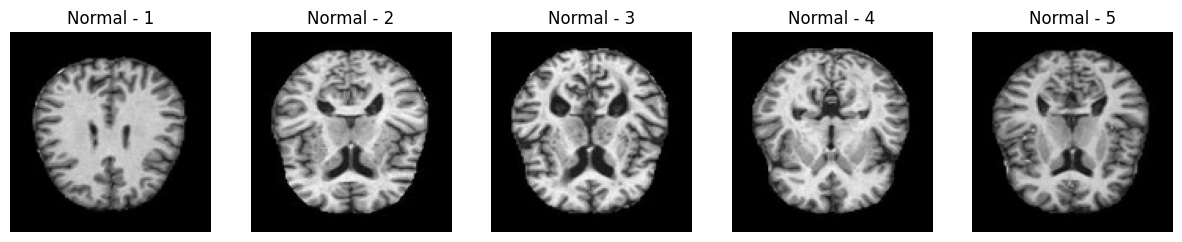

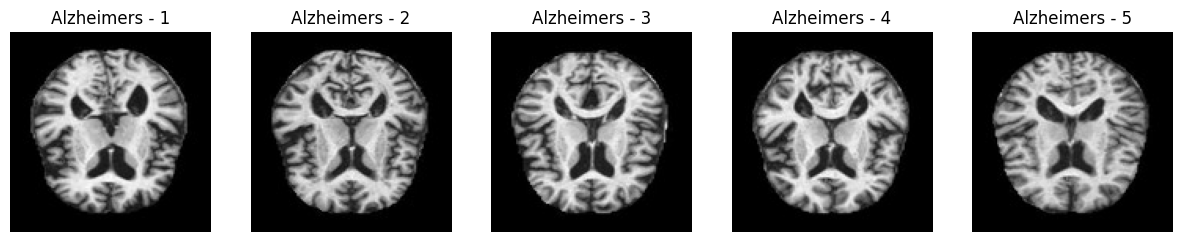

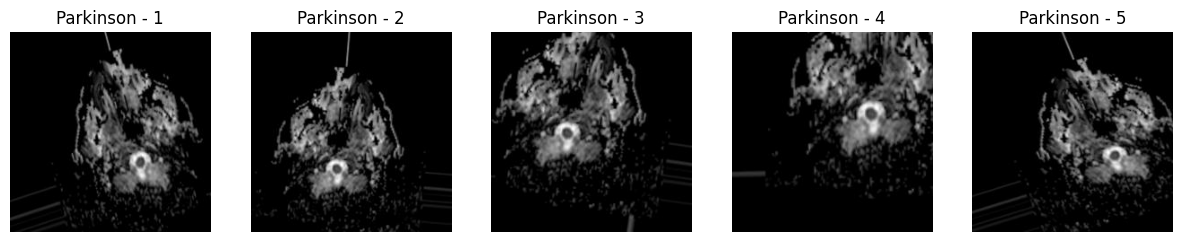

In [ ]:
split.show_images()

Analizamos las dimensiones de las imágenes con el objetivo de trabajar con el mismo tamaño apra todas ellas:

In [ ]:
split.dimensions(base_dir)

Dimensiones de las imágenes de Normal:
[(128, 128), (232, 256), (364, 448), (260, 320), (250, 320), (192, 192), (512, 512)]
Dimensiones de las imágenes de Alzheimers:
[(128, 128)]
Dimensiones de las imágenes de Parkinson:
[(224, 224), (256, 256), (128, 128), (560, 560)]


Dado que existen varios timos de dimensiones en las imágenes, se redimensionan:

In [ ]:
#split.resize_images()

Como las imágenes ya han sido redimensionadas, se comprueba que se ha hecho bien:

In [ ]:
print("Dimensiones imágenes conjunto train")
split.dimensions(train_dir)
print("Dimensiones imágenes conjunto train")
split.dimensions(test_dir)
print("Dimensiones imágenes conjunto train")
split.dimensions(val_dir)

Dimensiones imágenes conjunto train
Dimensiones de las imágenes de Normal:
[(224, 224)]
Dimensiones de las imágenes de Alzheimers:
[(224, 224)]
Dimensiones de las imágenes de Parkinson:
[(224, 224)]
Dimensiones imágenes conjunto train
Dimensiones de las imágenes de Normal:
[(224, 224)]
Dimensiones de las imágenes de Alzheimers:
[(224, 224)]
Dimensiones de las imágenes de Parkinson:
[(224, 224)]
Dimensiones imágenes conjunto train
Dimensiones de las imágenes de Normal:
[(224, 224)]
Dimensiones de las imágenes de Alzheimers:
[(224, 224)]
Dimensiones de las imágenes de Parkinson:
[(224, 224)]
